In [ ]:
import sys
import numpy as np
import keras
from tensorflow.keras import models, layers
import tensorflow.keras
import tensorflow as tf
from keras.utils import np_utils
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
# from scipy.special import softmax
warnings.filterwarnings('ignore')

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
(x_train_raw, y_train), (x_test_raw, y_test) = fashion_mnist.load_data()
y_train_raw = y_train
y_test_raw = y_test
num_classes = 10
batch_size = 100

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
def re_scale(data,new_min=0,new_max=1):
	old_range=np.max(data)-np.min(data)
	old_min=np.min(data)
	new_range=new_max-new_min
	new_data=((data-old_min)*new_range)/old_range+new_min
	return np.reshape(new_data,[-1,28,28,1]).astype('float32')

In [ ]:
def normolize_data(train, test):
  train = re_scale(x_train)
  test = re_scale(x_test)
  
  return train, test

In [ ]:
x_train, x_test = normolize_data(x_train, x_test)
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

#flatten all train and test arrays
x_train_flat = np.array([x.flatten() for x in x_train])
#x_train_flat = x_train_flat[:10000]
x_test_flat = np.array([x.flatten() for x in x_test])

#flatten all train and test arrays
x_train_flat_raw = np.array([x.flatten() for x in x_train_raw])
#x_train_flat = x_train_flat[:10000]
x_test_flat_raw = np.array([x.flatten() for x in x_test_raw])
print('x_train shape:', x_train.shape)
print('x_test shape:',  x_test.shape)
print('x_train_flat shape:', x_train_flat.shape)
print('x_test_flat shape:',  x_test_flat.shape)
print(y_train.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
x_train_flat shape: (60000, 784)
x_test_flat shape: (10000, 784)
(60000, 10)


Distribution of Training and Testing Data

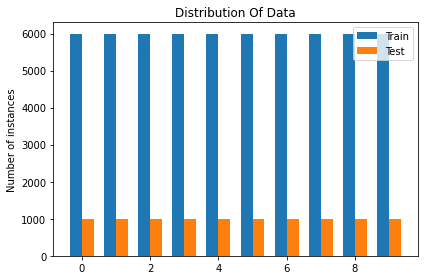

In [ ]:
y_dist_train = Counter(y_train_raw)
y_dist_test = Counter(y_test_raw)
x = np.arange(10)
y_dist_train = [int(y_dist_train[z]) for z in x]
y_dist_test = [y_dist_test[z] for z in x]


width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y_dist_train, width, label='Train')
rects2 = ax.bar(x + width/2, y_dist_test, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of instances')
ax.set_title('Distribution Of Data')
ax.legend()



fig.tight_layout()

plt.show()

In [ ]:
class GradientDescent:
    
    def __init__(self, x_val, y_val, learning_rate=.001, max_iters=1e3, epsilon=1e-8, batch_size=1000):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.x_val = x_val
        self.y_val = y_val
        
    def run(self, gradient_fn, x, y, weights, biases, model, dropout=False, dropout_percent=0):
        norms = np.array([np.inf])
        t = 1
        train_acc = []
        val_acc = []
        epoch = []
        while np.any(norms > self.epsilon) and t < self.max_iters:
            for i in range(len(y)//self.batch_size):
                l = i*batch_size
                r = min(l + batch_size, len(y))
                grad_W, grad_B = gradient_fn(x[l:r], y[l:r], l,r, dropout, dropout_percent)
                for p in range(len(weights)):
                    weights[p] -= self.learning_rate * grad_W[p]
                    biases[p] -= self.learning_rate * grad_B[p]
            train_yh = model.predict(x)
            val_yh = model.predict(self.x_val)
            train_acc.append(evaluate_acc(train_yh, y))
            val_acc.append(evaluate_acc(val_yh, self.y_val))
            epoch.append(t)
            t += 1
        
            norms = np.array([np.linalg.norm(g) for g in grad_W])

        plt.plot(epoch, train_acc, 'r')
        plt.plot(epoch, val_acc, 'b')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend(["Train", "Test"])
        plt.show()
        return weights, biases

In [ ]:
from IPython.core.display import display_json
leaky_relu = lambda z: np.maximum(0.01*z, z)
def leaky_relu_prime(z):
    dz = np.ones_like(z)
    dz[z < 0] = 0.01
    return dz

relu = lambda z: np.maximum(0,z)
relu_prime = lambda z: (z > 0).astype(z.dtype)

logistic = lambda z: 1./ (1 + np.exp(-z))
logistic_prime = lambda z: logistic(z)*(1-logistic(z))

tanh = lambda z: 2.*logistic(z) - 1
tanh_prime = lambda z: 1 - np.square(tanh(z))

linear = lambda z: z
linear_prime = lambda z: np.ones_like(z)

cube_root = lambda z: np.cbrt(z)
cube_root_prime = lambda z: np.where(z!=0, (1/(3*np.square(np.cbrt(z)))), 0)

swish = lambda z: z/(1 + np.exp(-z))
swish_prime = lambda z: swish(z)+logistic(z)*(1-swish(z))

def softmax(s):
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

class MLP:
    def __init__(self, active_func, active_func_prime, num_hidden_layers, width, optimizer, dropout=False, dropout_percent = 0):
        # Activation Function and its derivative
        self.active_func = active_func
        self.active_func_prime = active_func_prime

        # Depth = Number of weight sets = Num of layers - 1
        self.depth = num_hidden_layers + 1

        # Width = Number of nodes per layer in the hidden layer (is a list because it can changer per layer)
        self.width = width
        self.num_hidden_layers = num_hidden_layers
        self.optimizer = optimizer
        self.dropout = dropout
        self.dropout_percent = dropout_percent

    def computeValues(self,x,y):
        n_samples, n_features = x.shape
        n_classes = y.shape[1]

        if self.num_hidden_layers == 0:
            self.weights = [np.random.randn(n_features, num_classes).astype('float64')]
            self.bias = [np.zeros((1,n_classes)).astype('float64')]
        else:
            i_to_l1 = np.random.uniform(-1,1,(n_features, self.width[0])).astype('float64') * 0.1
            i_to_l1_b = np.zeros((1,self.width[0])).astype('float64')
            hidden_layer_weights = [np.random.uniform(-1,1,(self.width[i], self.width[i+1])).astype('float64')* 0.1 for i in range(self.num_hidden_layers-1)]
            hidden_layer_biases = [np.zeros((1, self.width[i+1])).astype('float64') for i in range(self.num_hidden_layers-1)]
            ln_to_o = np.random.uniform(-1,1,(self.width[-1], num_classes)).astype('float64')* 0.1
            ln_to_o_b = np.zeros((1,n_classes)).astype('float64')

            self.weights = [i_to_l1] + hidden_layer_weights + [ln_to_o]
            self.bias = [i_to_l1_b] + hidden_layer_biases + [ln_to_o_b]
        self.values = [0 for i in range(self.depth+1)]
        self.pre_active_values = [0 for i in range (self.depth)]

    def fit(self,x,y):
        # pre_active_values(z) -> Vx,
        # values(a) -> z
        num_samples, num_features = x.shape
        _, num_classes = y.shape
        # finish initializing the weights
        self.computeValues(x,y)
        self.values[0] = x
        self.weights, self.bias = self.optimizer.run(self.gradient, x, y, self.weights, self.bias, self, self.dropout, self.dropout_percent)
        #print(self.weights)
        return self
    
    def gradient(self, x,y,l,r, dropout=False, dropout_percent = 0):
        # Forwards
        for i in range(1, len(self.values)-1):
            # values[0] = x, weight[0] = weights between input and layer 1, bias[0] = bias between input and layer 1
            self.pre_active_values[i-1] = np.dot(self.values[i-1], self.weights[i-1])+self.bias[i-1]
            self.values[i] = self.active_func(self.pre_active_values[i-1])
            if dropout:
                self.values[i] *= np.random.binomial([np.ones((self.values[i].shape))],1-dropout_percent)[0] * (1.0/(1-dropout_percent))
        self.pre_active_values[-1] = (np.dot(self.values[-2], self.weights[-1])+self.bias[-1])
        self.values[-1] = softmax(self.pre_active_values[-1])

        # Backwards
        chain = self.values[-1][l:r]-y   # dL/dy * dy/du
        grad_w = np.dot(self.values[-2][l:r].T, chain) / x.shape[0]
        grad_w_b = np.sum(chain, axis=0, keepdims=True) / x.shape[0] 
        derivs_w = [grad_w]
        derivs_w_b = [grad_w_b] 

        for i in range(1, self.depth):
            chain = np.dot(chain, self.weights[-i].T) * self.active_func_prime(self.pre_active_values[-i-1][l:r])
            grad_v = np.dot(self.values[-i-2][l:r].T, chain) / x.shape[0] #dV
            grad_v_b = np.sum(chain, axis=0, keepdims=True) / x.shape[0] 
            derivs_w.append(grad_v)
            derivs_w_b.append(grad_v_b)

        return list(reversed(derivs_w)), list(reversed(derivs_w_b))
        
    def predict(self, x):
        # Start with x as input
        input_per_layer = x    

        for i in range(len(self.weights)-1):
            input_per_layer = self.active_func(np.dot(input_per_layer, self.weights[i]))
        
        yh = softmax(np.dot(input_per_layer, self.weights[-1]))
        return yh

def evaluate_acc(y_pred, y_true):
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_true, axis=1)
    return np.sum(y_pred == y_true)/y_pred.shape[0]
    
    

## Task 1

No layers



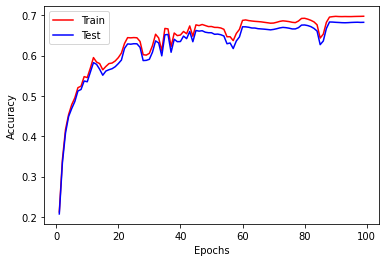

Train:  0.6977666666666666
Test:  0.6827


In [ ]:
grad = GradientDescent(x_test_flat, y_test,learning_rate=0.01, max_iters=100, batch_size=10000)
mlp = MLP(relu , relu_prime, 0, [], grad)

mlp.fit(x_train_flat,y_train)

yh = mlp.predict(x_test_flat)
ytrainh = mlp.predict(x_train_flat)

np.set_printoptions(threshold=sys.maxsize)

print("Train: ", evaluate_acc(ytrainh, y_train))
print("Test: ", evaluate_acc(yh, y_test))



1 Hidden Layer

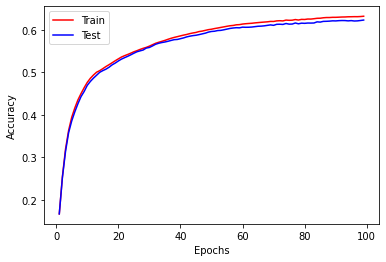

Train:  0.6324166666666666
Test:  0.6234


In [ ]:
grad = GradientDescent(x_test_flat, y_test,learning_rate=0.01, max_iters=100, batch_size=10000)
mlp = MLP(relu , relu_prime, 1, [128], grad)

mlp.fit(x_train_flat,y_train)

yh = mlp.predict(x_test_flat)
ytrainh = mlp.predict(x_train_flat)

np.set_printoptions(threshold=sys.maxsize)

print("Train: ", evaluate_acc(ytrainh, y_train))
print("Test: ", evaluate_acc(yh, y_test))

2 Hidden Layer

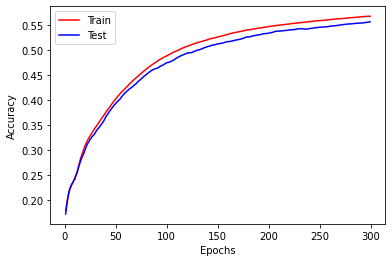

Train:  0.56755
Test:  0.5565


In [ ]:
grad = GradientDescent(x_test_flat, y_test,learning_rate=0.0001, max_iters=300, batch_size=10000)
mlp = MLP(relu , relu_prime, 2, [128,128], grad)

mlp.fit(x_train_flat,y_train)

yh = mlp.predict(x_test_flat)
ytrainh = mlp.predict(x_train_flat)

np.set_printoptions(threshold=sys.maxsize)

print("Train: ", evaluate_acc(ytrainh, y_train))
print("Test: ", evaluate_acc(yh, y_test))

## Task 2

Tanh

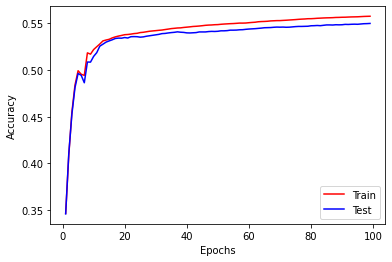

Train:  0.5575
Test:  0.5498


In [ ]:
grad = GradientDescent(x_test_flat, y_test,learning_rate=0.1, max_iters=100, batch_size=10000)
mlp = MLP(tanh , tanh_prime, 2, [128,128], grad)

mlp.fit(x_train_flat,y_train)

yh = mlp.predict(x_test_flat)
ytrainh = mlp.predict(x_train_flat)

np.set_printoptions(threshold=sys.maxsize)

print("Train: ", evaluate_acc(ytrainh, y_train))
print("Test: ", evaluate_acc(yh, y_test))

Leaky-relu

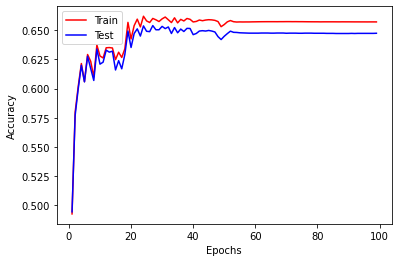

Train:  0.6572333333333333
Test:  0.6475


In [ ]:
grad = GradientDescent(x_test_flat, y_test,learning_rate=0.01, max_iters=100, batch_size=10000)
mlp = MLP(leaky_relu , leaky_relu_prime, 2, [128,128], grad)

mlp.fit(x_train_flat,y_train)

yh = mlp.predict(x_test_flat)
ytrainh = mlp.predict(x_train_flat)

np.set_printoptions(threshold=sys.maxsize)

print("Train: ", evaluate_acc(ytrainh, y_train))
print("Test: ", evaluate_acc(yh, y_test))

## Task 3

Dropout

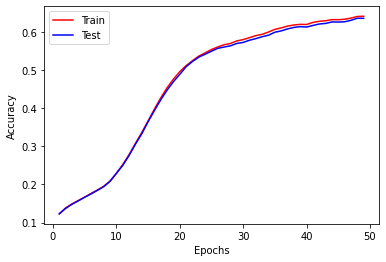

Train:  0.64075
Test:  0.6353


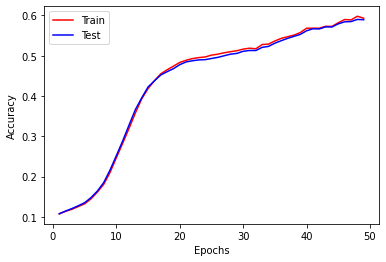

Train:  0.5931833333333333
Test:  0.5894


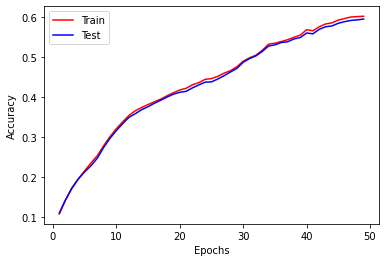

Train:  0.6024166666666667
Test:  0.5954


In [ ]:
grad = GradientDescent(x_test_flat, y_test,learning_rate=0.01, max_iters=50, batch_size=10000)
mlp = MLP(relu , relu_prime, 2, [128,128], grad, True, 0.1)
mlp.fit(x_train_flat,y_train)

yh = mlp.predict(x_test_flat)
ytrainh = mlp.predict(x_train_flat)

np.set_printoptions(threshold=sys.maxsize)

print("Train: ", evaluate_acc(ytrainh, y_train))
print("Test: ", evaluate_acc(yh, y_test))

grad = GradientDescent(x_test_flat, y_test,learning_rate=0.01, max_iters=50, batch_size=10000)
mlp = MLP(relu , relu_prime, 2, [128,128], grad, True, 0.2)
mlp.fit(x_train_flat,y_train)

yh = mlp.predict(x_test_flat)
ytrainh = mlp.predict(x_train_flat)

np.set_printoptions(threshold=sys.maxsize)

print("Train: ", evaluate_acc(ytrainh, y_train))
print("Test: ", evaluate_acc(yh, y_test))

grad = GradientDescent(x_test_flat, y_test,learning_rate=0.01, max_iters=50, batch_size=10000)
mlp = MLP(relu , relu_prime, 2, [128,128], grad, True, 0.3)
mlp.fit(x_train_flat,y_train)

yh = mlp.predict(x_test_flat)
ytrainh = mlp.predict(x_train_flat)

np.set_printoptions(threshold=sys.maxsize)

print("Train: ", evaluate_acc(ytrainh, y_train))
print("Test: ", evaluate_acc(yh, y_test))

## Task 4

Training with unnormalized images

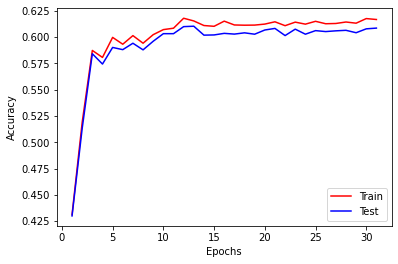

Train:  0.6167833333333334
Test:  0.6086


In [ ]:
grad = GradientDescent(x_test_flat, y_test,learning_rate=0.1, max_iters=100, batch_size=10000)
mlp = MLP(relu, relu_prime, 2, [128,128], grad)

mlp.fit(x_train_flat_raw,y_train)

yh = mlp.predict(x_test_flat_raw)
ytrainh = mlp.predict(x_train_flat_raw)

np.set_printoptions(threshold=sys.maxsize)

print("Train: ", evaluate_acc(ytrainh, y_train))
print("Test: ", evaluate_acc(yh, y_test))

## Task 5

Neural Network Using Keras

In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=784))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10))
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(x_train_flat, y_train_raw, epochs=10, validation_data=(x_test_flat,y_test_raw))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               100480    
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4834 - accuracy: 0.8264 - val_loss: 0.4221 - val_accuracy: 0.8485
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3618 - accuracy: 0.8668 - val_loss: 0.3845 - val_accuracy: 0.8602
Epoch 3/10
1875/1875 [==

313/313 - 0s - loss: 0.3583 - accuracy: 0.8813 - 421ms/epoch - 1ms/step


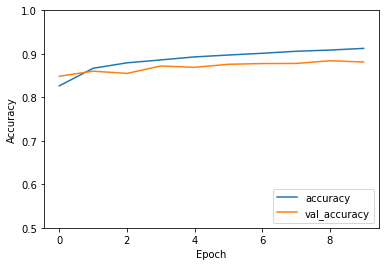

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test_flat,  y_test_raw, verbose=2)

CNN using Keras

In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(28,28,1)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10))
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(x_train, y_train_raw, epochs=10, validation_data=(x_test,y_test_raw))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 128)               4718720   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 4,755,338
Trainable params: 4,755,338
Non-

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test_raw, verbose=2)

## Task 6

Finding the best model

In [ ]:
activation_fx = [(relu, relu_prime, 'relu'), (logistic, logistic_prime, 'sigmoid'), (swish, swish_prime, 'swish'), (cube_root, cube_root_prime, 'cbrt')]
num_layers = [1,2,3]
num_nodes = [32, 64, 128]

grad = GradientDescent(x_test_flat, y_test,learning_rate=0.5, max_iters=50, batch_size=10000)

scores = []

for act, act_prime, act_str in activation_fx:
    for num_layer in num_layers:
        for num_node in num_nodes:
            
            mlp = MLP(act, act_prime, num_layer, [num_node]*num_layer, grad)

            mlp.fit(x_train_flat,y_train)

            yh = mlp.predict(x_test_flat)
            ytrainh = mlp.predict(x_train_flat)

            config = "[" + act_str + "]" + "[" + str(num_layer) + "-hidden" + "]" + "[" + str(num_node) + "-nodes" + "]"
            trainscore = evaluate_acc(ytrainh, y_train)
            testscore = evaluate_acc(yh, y_test)


            scores.append((config, trainscore, testscore))

for config, trainscore, testscore in scores:
    print("Train" + config + ": ", trainscore)
    print("Test" + config + ": ", testscore)
    print()

best_config, best_trainscore, best_testscore = max(scores, key=lambda item: item[2])
print("The best model is:")
print("Train" + best_config + ": ", best_trainscore)
print("Test" + best_config + ": ", best_testscore)